In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

jax.config.update("jax_enable_x64", True)

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

#jax.config.update("jax_enable_x64", True)


import chainconsumer as cc

import numpyro as npy
import numpyro.distributions as dist
from numpyro.infer.reparam import LocScaleReparam

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior
from fitting import *
from plotting import *

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

In [3]:
wid = 64
oversample = 4

nwavels = 20
npoly=5

optics = NICMOSOptics(512, wid, oversample)

detector = NICMOSDetector(oversample, wid)

ddir = "../data/MAST_2024-09-22T03_37_01.724Z/HST/"


files = [
    #'n8yj53vfq_cal.fits'

    'n8yj59glq_cal.fits',

]

exposures_single = [exposure_from_file(ddir + file, SinglePointPolySpectrumFit(nwavels), crop=wid) for file in files]

exposures_binary = [exposure_from_file(ddir + file, BinaryPolySpectrumFit(nwavels), crop=wid) for file in files]

Filename: ../data/MAST_2024-09-22T03_37_01.724Z/HST/n8yj59glq_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     309   ()      
  1  SCI           1 ImageHDU       143   (256, 256)   float32   
  2  ERR           1 ImageHDU        71   (256, 256)   float32   
  3  DQ            1 ImageHDU        71   (256, 256)   int16   
  4  SAMP          1 ImageHDU        71   (256, 256)   int16   
  5  TIME          1 ImageHDU        71   (256, 256)   float32   
None
Filename: ../data/MAST_2024-09-22T03_37_01.724Z/HST/n8yj59glq_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     309   ()      
  1  SCI           1 ImageHDU       143   (256, 256)   float32   
  2  ERR           1 ImageHDU        71   (256, 256)   float32   
  3  DQ            1 ImageHDU        71   (256, 256)   int16   
  4  SAMP          1 ImageHDU        71   (256, 256)   int16   
  5  TIME          1 ImageHDU        71  

In [4]:
params = {
    #"fluxes": {},
    "positions": {},
    "spectrum": {},
    "aberrations": {},
    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    "scale": 0.0432,
    "rot": 0.,
    "softening": 2.,
}

for exp in exposures_single:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])
    params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.zeros(npoly).at[0].set(1)*np.log10(np.nansum(exp.data)/nwavels)
    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(26)
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = -np.asarray([-0.06, -0.06])*1e2
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = -45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = -45. #+ 180.
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])

model_single = set_array(NICMOSModel(exposures_single, params, optics, detector))
model_binary = set_array(NICMOSModel(exposures_binary, params, optics, detector))


params = ModelParams(params)

In [5]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

base_adam = lambda vals: optax.adam(vals)
opta = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))


def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]



g = 5e-3

things = {
    #"fluxes" : opt(g*20,10),
    "positions": opt(g*30, 0),
    "spectrum": opt(g*20, 10),#, (20, 1.5)),
    "cold_mask_shift": opt(g*500, 120),
    "cold_mask_rot": opt(g*500, 120),
    #"cold_mask_scale": opt(g*3000, 150),
    #"cold_mask_shear": opt(g*1000, 150),
    #"primary_scale": opt(g*100, 150),
    #"primary_rot": opt(g*100, 150),
    #"primary_shear": opt(g*100, 150),
    #"aberrations": opt(g*100,20),#, (150, g*0.2)),
    #"spectrum": opt(g*50, 20)#, (150, g*200), (200, g*300), (250, g*400)),
    #"spectrum": opt(g*0.01, 20),
    #"softening": opt(g*1e3, 200),
    #"breathing": opt(g*1000,150),
    #"rot": opt(g*100, 50),
}

groups = list(things.keys())
paths = flatten(groups)
optimisers = [things[i] for i in groups]
groups = [list(x) if isinstance(x, tuple) else x for x in groups]

In [6]:
losses, models = optimise(params, model_single, exposures_single, things, 20)

Calculating Fishers


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

{'n8yj59glq': {'positions': Array([[5.51033004e+08, 1.99301584e+07],
       [1.99301584e+07, 4.17368380e+08]], dtype=float64), 'spectrum': Array([[ 8.64187184e+09, -5.29096743e+08,  3.20527764e+09,
        -2.90210059e+08,  2.13726695e+09],
       [-5.29096743e+08,  1.00698271e+09, -2.57153185e+08,
         6.60761511e+08, -1.81776978e+08],
       [ 3.20527764e+09, -2.57153185e+08,  1.46941219e+09,
        -1.56254073e+08,  1.05847959e+09],
       [-2.90210059e+08,  6.60761511e+08, -1.56254073e+08,
         5.11971611e+08, -1.16004095e+08],
       [ 2.13726695e+09, -1.81776978e+08,  1.05847959e+09,
        -1.16004095e+08,  8.00869891e+08]], dtype=float64), 'cold_mask_shift': Array([[-17909311.30923257,   2009377.87104065],
       [  2009377.87104065, -17942209.61574162]], dtype=float64), 'cold_mask_rot': Array([[-32487635.04530433]], dtype=float64)}}
Fitting Model


  0%|          | 0/20 [00:00<?, ?it/s]

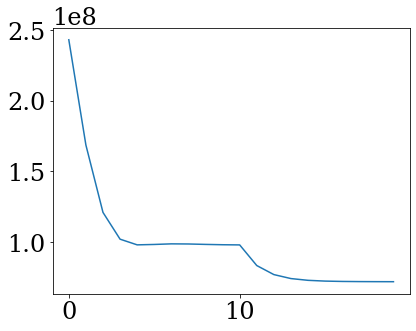

In [7]:
plt.plot(losses[-20:])

4


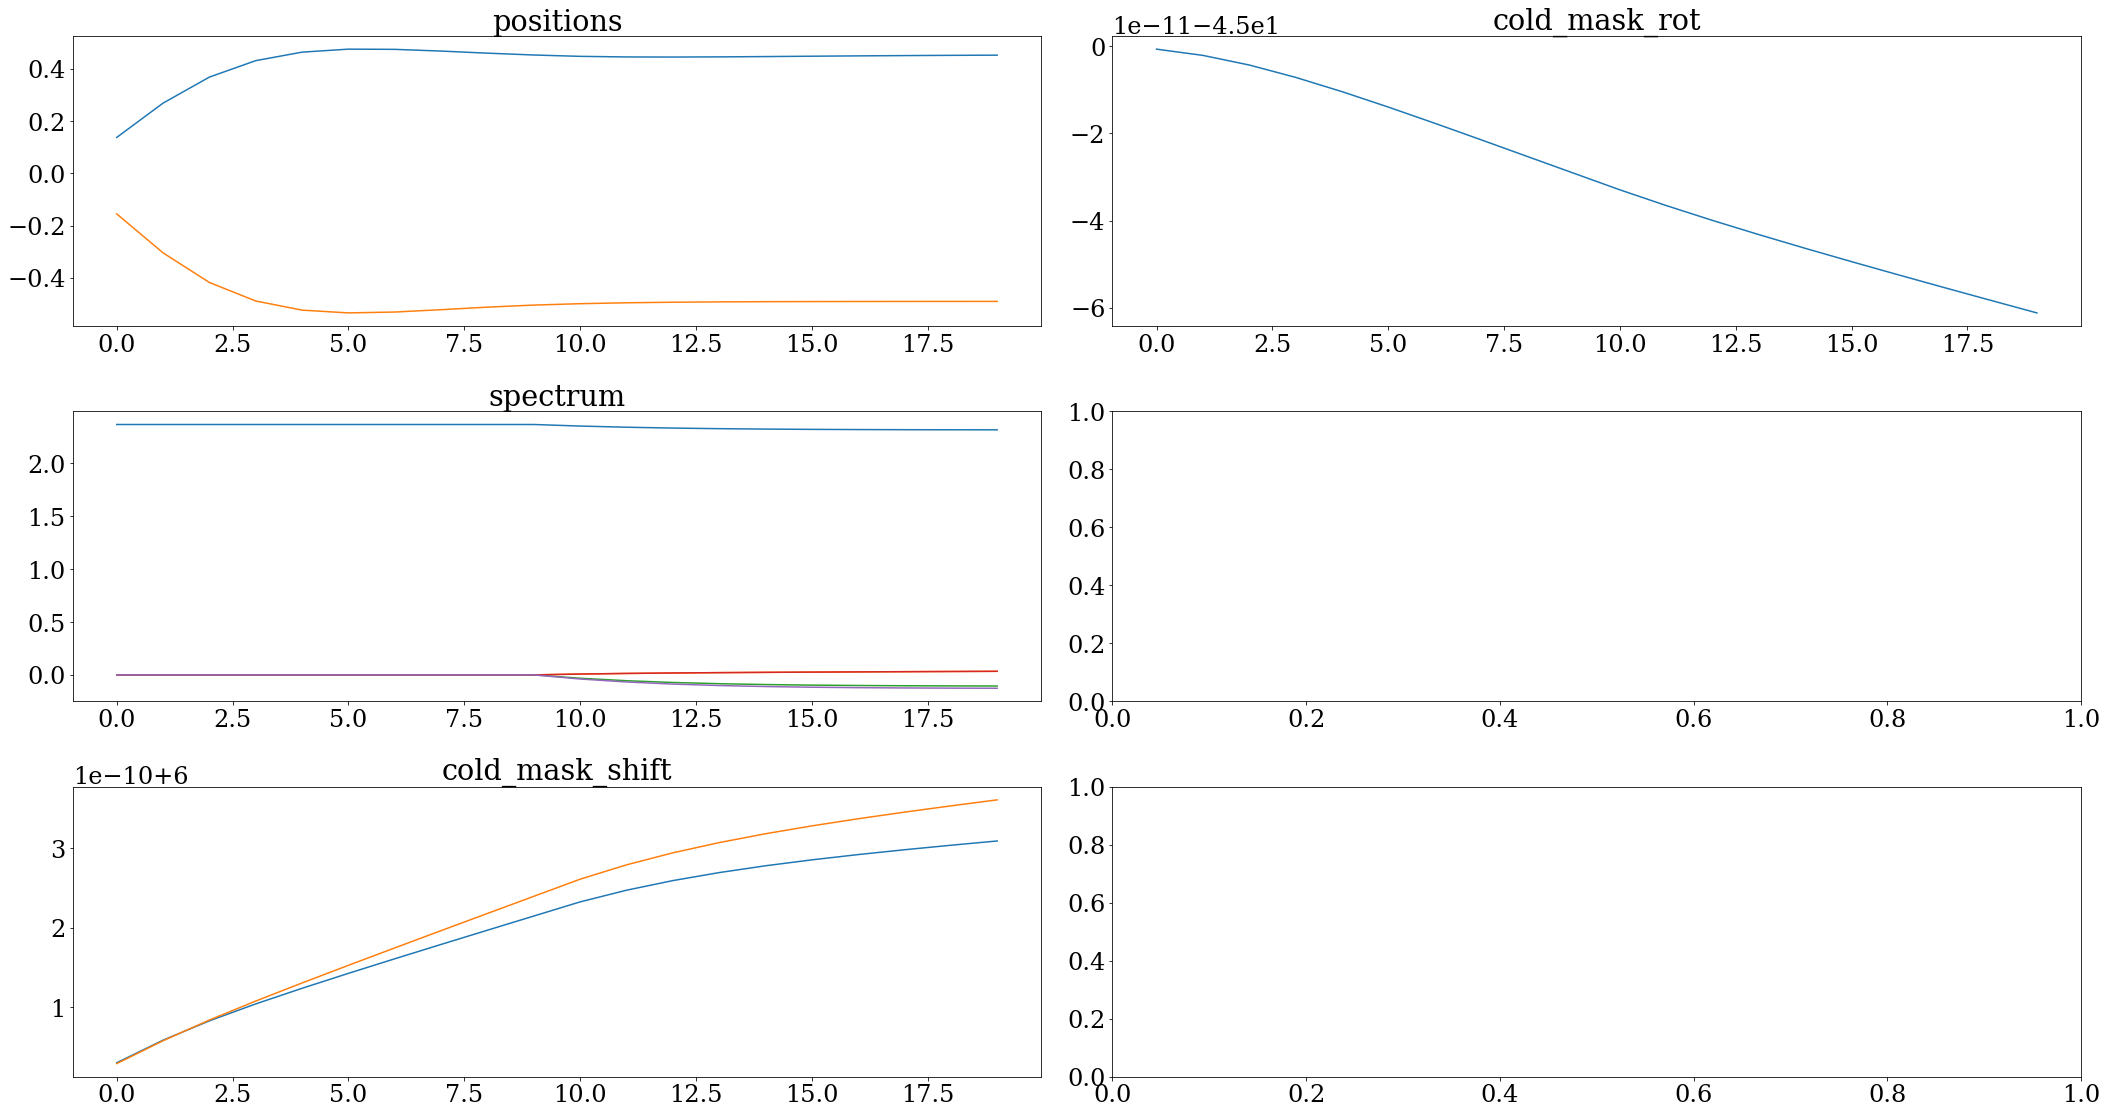

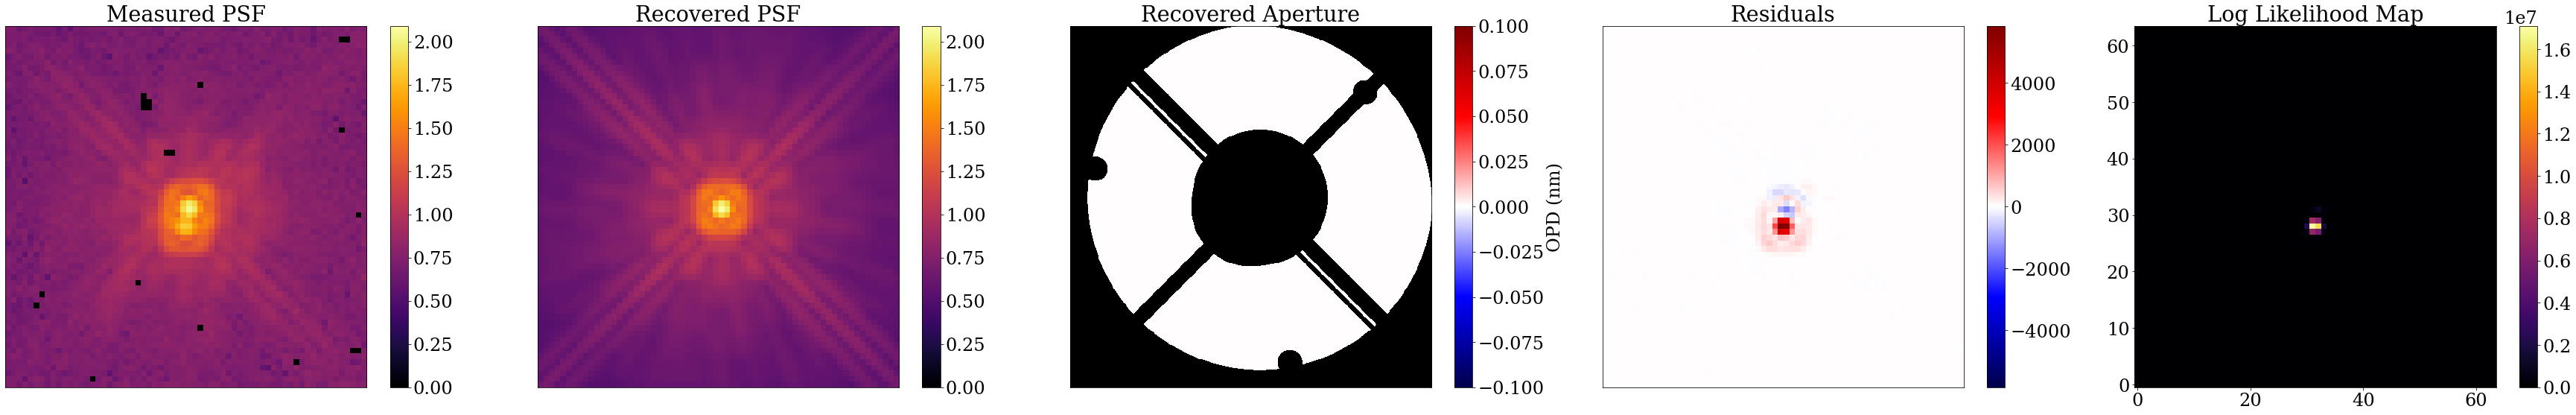

In [8]:
plot_params(models, groups, xw = 3)
plot_comparison(model_single, models[-1], exposures_single)

In [9]:
#potato

In [10]:
#plot_spectra(model_single, models[-1], exposures_single)

In [11]:
def tree_mul(spec, val):
    return jtu.tree_map(lambda x: x*val, spec)

def tree_sum(spec, val):
    return jtu.tree_map(lambda x: x+val, spec)


def extract_binary_params(params, exposures, x, y, theta, r, flux, contrast):
    #fluxes = dlu.fluxes_from_contrast(flux, contrast)
    param_dict = params.params.copy()
    param_dict["primary_spectrum"] = param_dict["spectrum"]
    param_dict["secondary_spectrum"] = param_dict["spectrum"]
    param_dict["fluxes"] = dlu.list2dictionary([(exp.fit.get_key(exp, "fluxes"), flux) for exp in exposures], ordered=True)#tree_mul(param_dict["spectrum"], fluxes[0])
    param_dict["contrast"] = dlu.list2dictionary([(exp.fit.get_key(exp, "contrast"), contrast) for exp in exposures], ordered=True) #tree_mul(param_dict["spectrum"], fluxes[1])
    param_dict["positions"] = tree_sum(param_dict["positions"], np.array([x,y]))
    param_dict["separation"] = r#dlu.list2dictionary([(exp.fit.get_key(exp, "separation"), r) for exp in exposures])
    param_dict["position_angle"] = theta #dlu.list2dictionary([(exp.fit.get_key(exp, "position_angle"), theta) for exp in exposures])
    return ModelParams(param_dict)


"""def inject_binary_values(x, y, theta, r, flux, contrast, initial_params):
    fluxes = dlu.fluxes_from_contrast(flux, contrast)
    injected_params = ModelParams({
        "primary_spectrum": spectra_mul(initial_params.get("primary_spectrum"),fluxes[0]),
        "secondary_spectrum": spectra_mul(initial_params.get("secondary_spectrum"),fluxes[1]),
        "positions": np.asarray([x,y]),
        "position_angle": theta,
        "separation": r
    })
    return injected_params.inject(initial_params)
"""

'def inject_binary_values(x, y, theta, r, flux, contrast, initial_params):\n    fluxes = dlu.fluxes_from_contrast(flux, contrast)\n    injected_params = ModelParams({\n        "primary_spectrum": spectra_mul(initial_params.get("primary_spectrum"),fluxes[0]),\n        "secondary_spectrum": spectra_mul(initial_params.get("secondary_spectrum"),fluxes[1]),\n        "positions": np.asarray([x,y]),\n        "position_angle": theta,\n        "separation": r\n    })\n    return injected_params.inject(initial_params)\n'

In [12]:
binary_params = extract_binary_params(models[-1], exposures_binary, 0., 0., 0., 0., 0., 1.)
model_binary = set_array(NICMOSModel(exposures_binary, binary_params.params, optics, detector))


In [13]:
def loss_fn(params, exposures, model):
    mdl = params.inject(model)
    return np.nansum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))


In [14]:
#things = {"primary_spectrum": opt(4e-6, 0), "secondary_spectrum": opt(4e-6, 0)}#, "contrast": opt(1e-8, 10)}
things = {"fluxes": opt(5e-11, 0)}#, "contrast": opt(5e-11, 10)}

@zdx.filter_jit
@zdx.filter_value_and_grad(list(things.keys()))
def binary_loss_fn(params, exposures, model):
    mdl = params.inject(model)
    return np.nansum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))

def binary_optimise(params, model, exposures, things, niter):
    paths = list(things.keys())
    optimisers = [things[i] for i in paths]
    
    optim, opt_state = zdx.get_optimiser(
        params, paths, optimisers
    )

    losses, models = [], []
    for i in (range(niter)):
        loss, grads = binary_loss_fn(params,exposures, model)
        #grads = jtu.tree_map(lambda x, y: x * np.abs(y), grads, ModelParams(lrs.params))
        updates, opt_state = optim.update(grads, opt_state)
        params = zdx.apply_updates(params, updates)

        models.append(params)
        losses.append(loss)
    
    return losses, models

In [15]:
binary_params

ModelParams(
  params={
    'aberrations':
    {'n8yj59glq': f64[26]},
    'cold_mask_rot':
    {'F110W': f64[]},
    'cold_mask_scale':
    {'F110W': f64[2]},
    'cold_mask_shear':
    {'F110W': f64[2]},
    'cold_mask_shift':
    {'n8yj59glq': f64[2]},
    'outer_radius':
    1.146,
    'positions':
    {'n8yj59glq': f64[2]},
    'primary_rot':
    {'F110W': -45.0},
    'primary_scale':
    {'F110W': f64[2]},
    'primary_shear':
    {'F110W': f64[2]},
    'rot':
    0.0,
    'scale':
    0.0432,
    'secondary_radius':
    0.44639999999999996,
    'softening':
    2.0,
    'spectrum':
    {'U20081_F110W': f64[5]},
    'spider_width':
    0.0924,
    'primary_spectrum':
    {'U20081_F110W': f64[5]},
    'secondary_spectrum':
    {'U20081_F110W': f64[5]},
    'fluxes':
    {'U20081_F110W': 0.0},
    'contrast':
    {'F110W': 1.0},
    'separation':
    0.0,
    'position_angle':
    0.0
  }
)

In [16]:
x_vals = np.linspace(-5, 5, 4)
y_vals = np.linspace(-5, 5, 4)
theta_vals = np.arange(4)*np.pi/2#np.linspace(0, 2*np.pi, 4)
r_vals = np.asarray([1.5, 3])#np.linspace(0, 5, 2)

min_loss = np.inf
best_params = None

for x in x_vals:
    for y in y_vals:
        for theta in theta_vals:
            for r in r_vals:
                binary_params = extract_binary_params(models[-1], exposures_binary, x, y, theta, r, 0., 1.)
                #binary_params = extract_binary_params(models[-1], exposures_binary, 0, 0, 0, 0, 0., 1.)#np.log10(0.5), 1.)
                losses, bms = binary_optimise(binary_params, model_binary, exposures_binary, things, 20)
                print(losses[-1])
                if losses[-1] < min_loss and min_loss != 0.0:
                    min_loss = losses[-1]
                    best_params = bms[-1]
                

352379004.4623088
353146842.4954486
352367129.7453684
353062829.694418
352354532.48433864
352974641.110868
352341262.0071286
352882717.6827179
346743007.69384664
347511500.6539844
346737188.41282046
347475032.22448945
346729162.2024104
347430527.59052455
346718971.35476124
347378357.4691958
351433075.94565994
352235217.4789759
351445966.23713607
352323701.01514673
351457655.077626
352405810.36256194
351468097.37836224
352481052.9612437
356832589.19892406
359066805.4433858
356846936.0518327
359148110.9288228
356860994.02088475
359226010.7471955
356874717.8203599
359300190.0502636
324021514.10854304
302111945.5325563
323767800.7200528
300889590.56071585
323523960.65597
299703489.6643007
323290932.8651981
298560491.7260056
251474765.42163396
212996879.682469
251379153.86067045
212308209.35510546
251294532.3478445
211635960.8238858
251221153.79026744
210981548.92349565
310844513.70502555
298232134.30992395
311247076.40969604
299880331.77353954
311645720.4714332
301489543.30333495
312039332

In [17]:
best_params

ModelParams(
  params={
    'aberrations':
    {'n8yj59glq': f64[26]},
    'cold_mask_rot':
    {'F110W': f64[]},
    'cold_mask_scale':
    {'F110W': f64[2]},
    'cold_mask_shear':
    {'F110W': f64[2]},
    'cold_mask_shift':
    {'n8yj59glq': f64[2]},
    'contrast':
    {'F110W': 1.0},
    'fluxes':
    {'U20081_F110W': f64[]},
    'outer_radius':
    1.146,
    'position_angle':
    f64[],
    'positions':
    {'n8yj59glq': f64[2]},
    'primary_rot':
    {'F110W': -45.0},
    'primary_scale':
    {'F110W': f64[2]},
    'primary_shear':
    {'F110W': f64[2]},
    'primary_spectrum':
    {'U20081_F110W': f64[5]},
    'rot':
    0.0,
    'scale':
    0.0432,
    'secondary_radius':
    0.44639999999999996,
    'secondary_spectrum':
    {'U20081_F110W': f64[5]},
    'separation':
    f64[],
    'softening':
    2.0,
    'spectrum':
    {'U20081_F110W': f64[5]},
    'spider_width':
    0.0924
  }
)

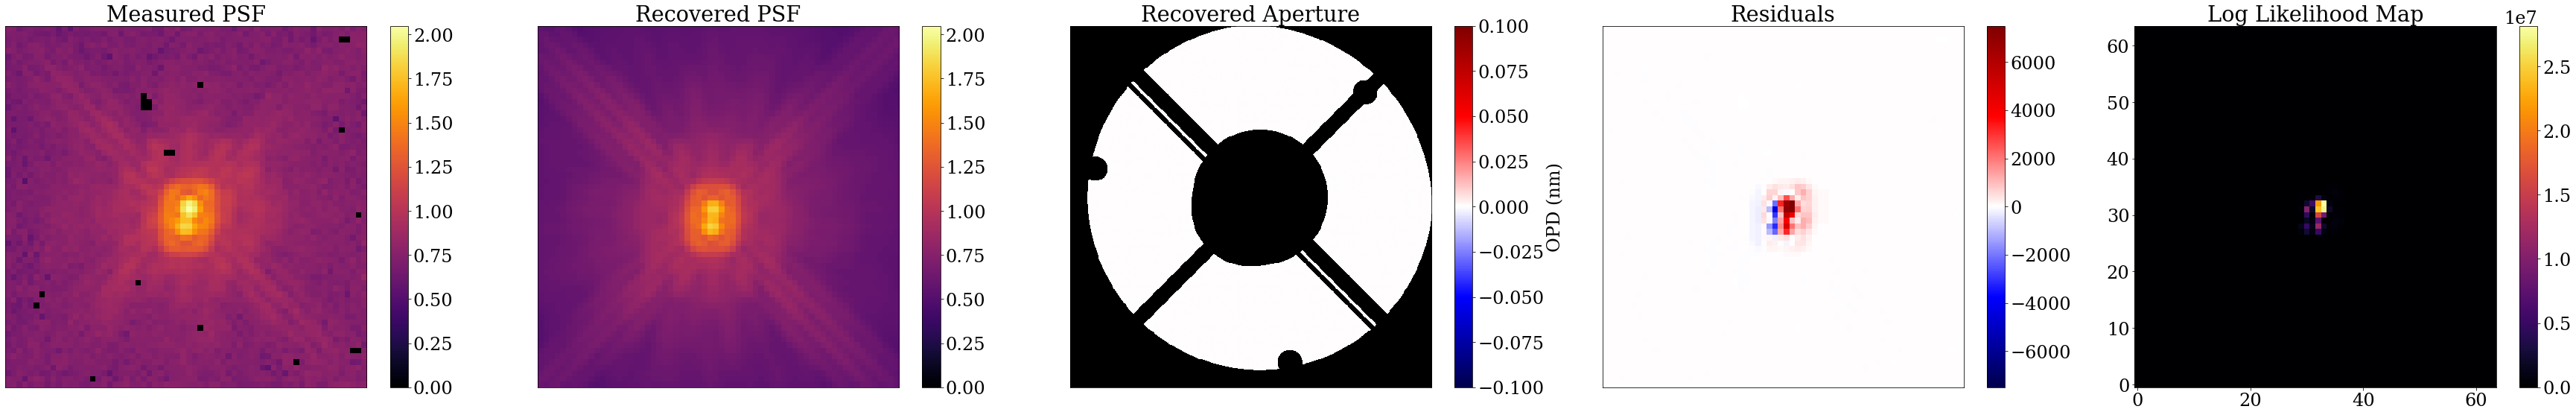

In [18]:
plot_comparison(model_binary, best_params, exposures_binary)

In [19]:
g = 5e-3
things = {
    #"fluxes" : opt(g*20,10),
    "positions": opt(g*100, 0),
    "separation": opt(g*30, 0),
    "position_angle": opt(g*1e-4, 10),
    "primary_spectrum": opt(g*50, 20),
    "secondary_spectrum": opt(g*50, 20),#, (20, 1.5)),
    "cold_mask_shift": opt(g*5000, 120),
    "cold_mask_rot": opt(g*500, 120),
    #"cold_mask_scale": opt(g*3000, 150),
    #"cold_mask_shear": opt(g*1000, 150),
    #"primary_scale": opt(g*100, 150),
    #"primary_rot": opt(g*100, 150),
    #"primary_shear": opt(g*100, 150),
    "aberrations": opt(g*100,30),#, (150, g*0.2)),
    #"spectrum": opt(g*50, 20)#, (150, g*200), (200, g*300), (250, g*400)),
    #"spectrum": opt(g*0.01, 20),
    #"softening": opt(g*1e3, 200),
    #"breathing": opt(g*1000,150),
    #"rot": opt(g*100, 50),
}
groups = list(things.keys())


In [21]:
losses, models = optimise(best_params, set_array(model_binary), exposures_binary, things, 300)

Calculating Fishers


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

{'n8yj59glq': {'positions': Array([[ 1.58895409e+09, -4.70566077e+06],
       [-4.70566077e+06,  1.29316354e+09]], dtype=float64), 'separation': Array([[-1.37019028e+08]], dtype=float64), 'position_angle': Array([[0.]], dtype=float64), 'primary_spectrum': Array([[5.96960959e+09, 4.02797717e+07, 1.87747690e+09, 6.05631920e+07,
        1.15270609e+09],
       [4.02797717e+07, 9.62306566e+08, 2.59503367e+07, 5.86499786e+08,
        2.49856933e+07],
       [1.87747690e+09, 2.59503367e+07, 8.71347424e+08, 3.44727123e+07,
        6.15094459e+08],
       [6.05631920e+07, 5.86499786e+08, 3.44727123e+07, 4.38479384e+08,
        3.06418044e+07],
       [1.15270609e+09, 2.49856933e+07, 6.15094459e+08, 3.06418044e+07,
        4.71574318e+08]], dtype=float64), 'secondary_spectrum': Array([[5.96960959e+09, 4.02797717e+07, 1.87747690e+09, 6.05631920e+07,
        1.15270609e+09],
       [4.02797717e+07, 9.62306566e+08, 2.59503367e+07, 5.86499786e+08,
        2.49856933e+07],
       [1.87747690e+09, 2.

  0%|          | 0/300 [00:00<?, ?it/s]

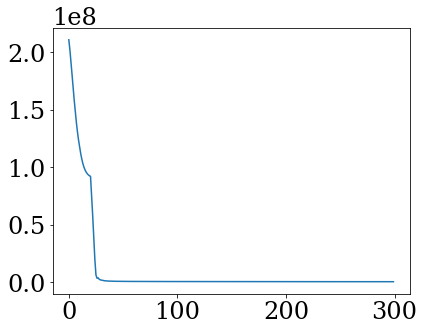

In [22]:
plt.plot(losses)

8


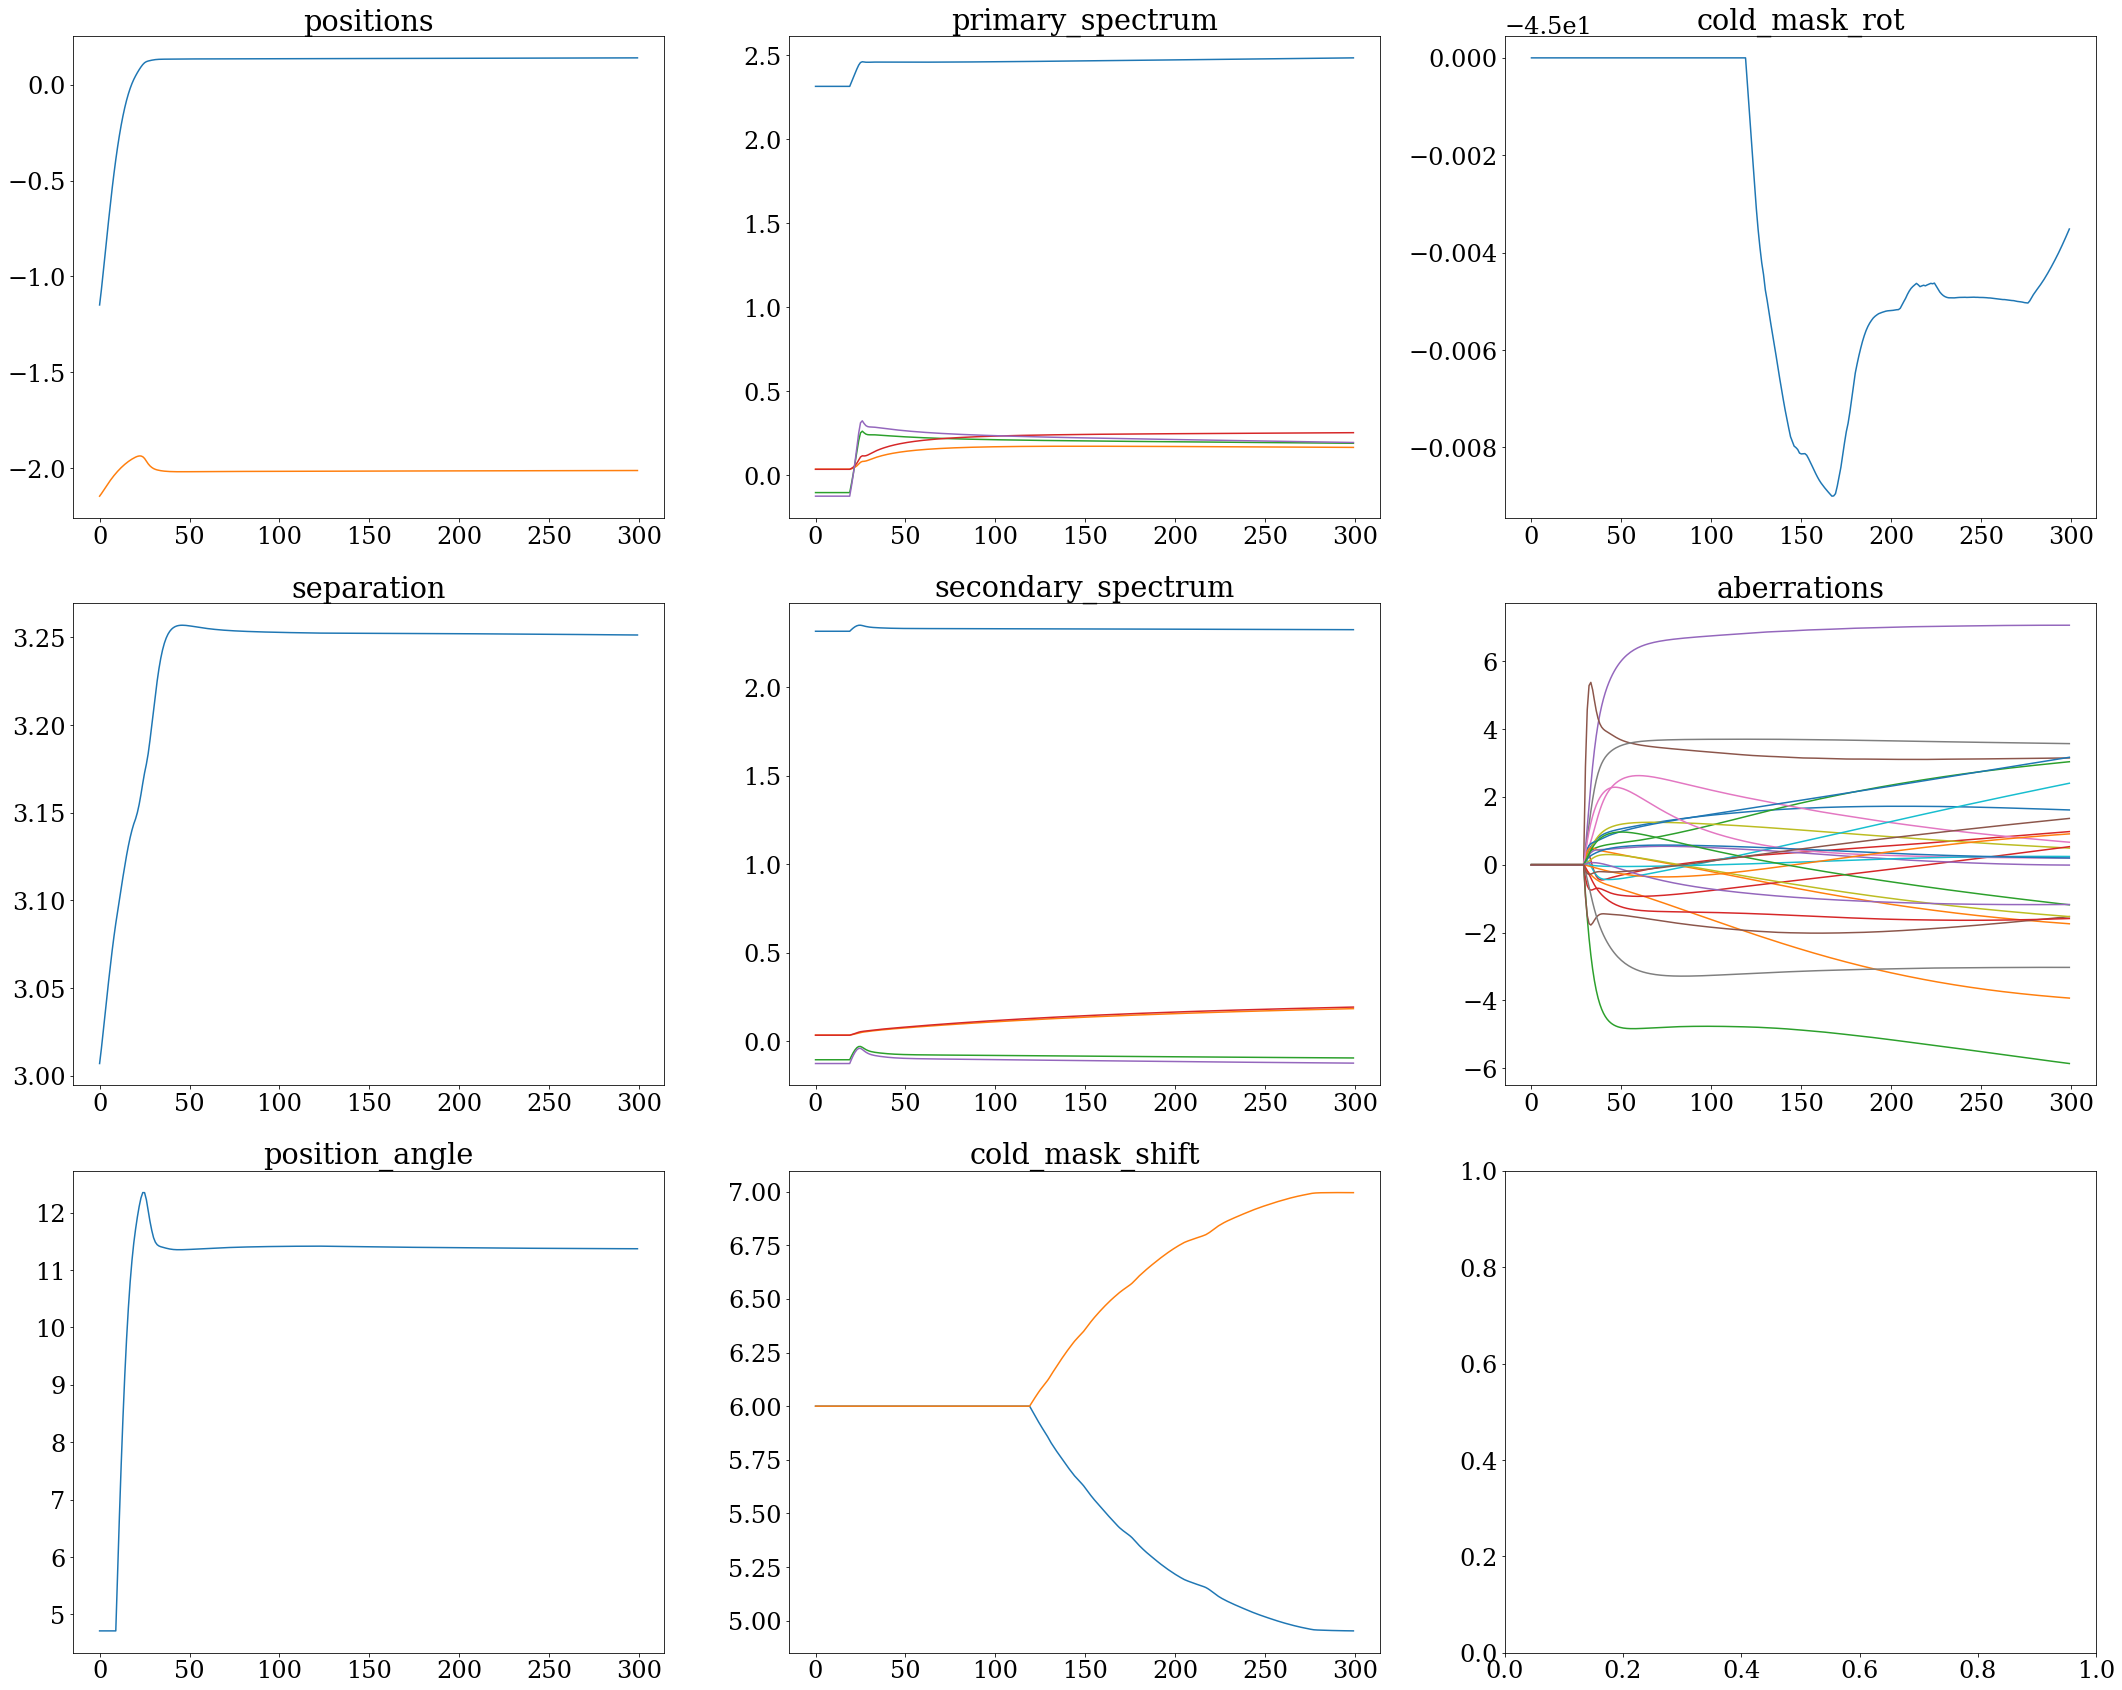

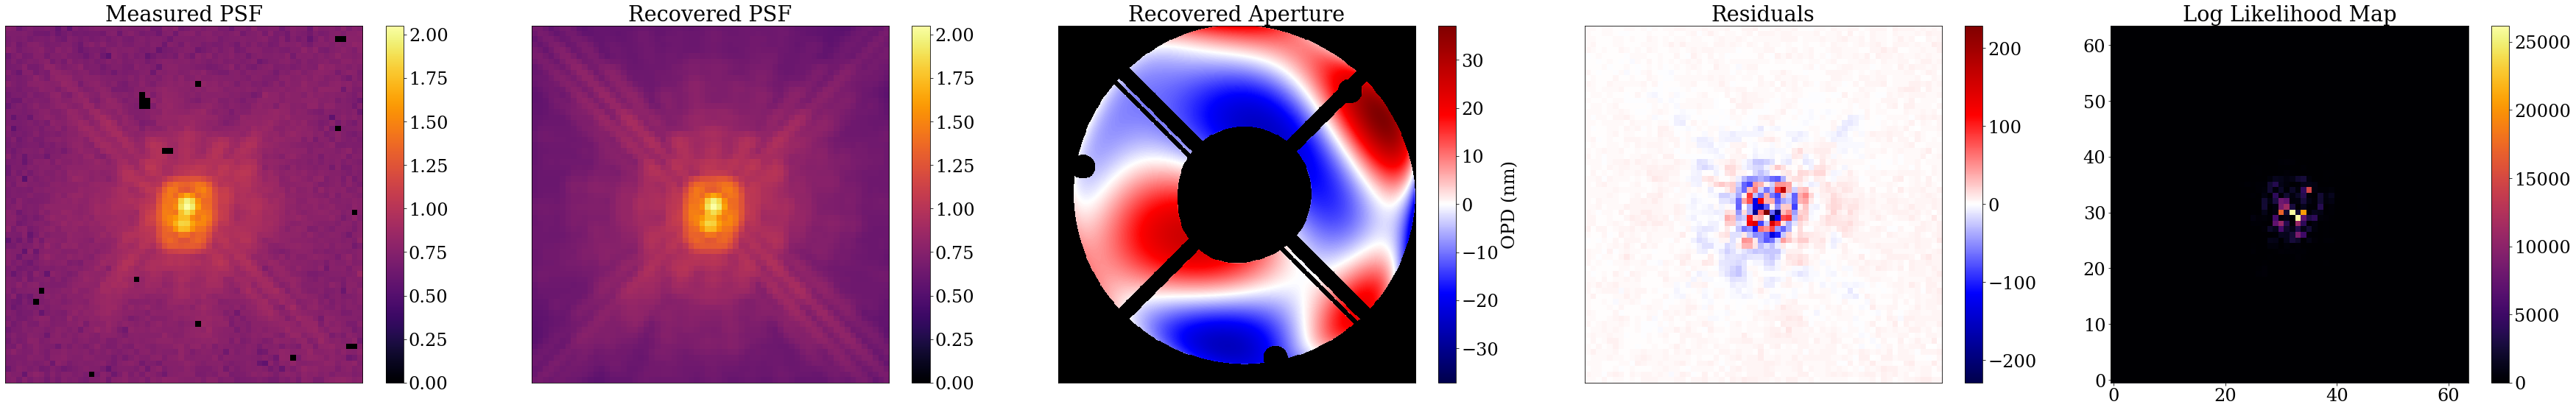

In [23]:
plot_params(models, groups, xw = 3)
plot_comparison(model_binary, models[-1], exposures_binary)

In [24]:
models[-1].params

{'aberrations': {'n8yj59glq': Array([ 1.6139325 , -3.92938082,  3.03428809,  0.9762199 ,  7.05615155,
          3.14563956,  0.66279922,  3.5678507 ,  0.48973107,  2.40058034,
          3.16516601, -1.73970976, -5.85726729,  0.53143434, -0.01091188,
         -1.52928541,  0.19273844, -3.02492805, -1.52844561,  0.24302021,
          0.1992252 ,  0.90849038, -1.18120154, -1.58531078, -1.17195604,
          1.36381625], dtype=float64)},
 'cold_mask_rot': {'F110W': Array(-45.00351431, dtype=float64)},
 'cold_mask_scale': {'F110W': Array([1., 1.], dtype=float64)},
 'cold_mask_shear': {'F110W': Array([0., 0.], dtype=float64)},
 'cold_mask_shift': {'n8yj59glq': Array([4.95263505, 6.99498959], dtype=float64)},
 'contrast': OrderedDict([('F110W', 1.0)]),
 'fluxes': OrderedDict([('U20081_F110W', Array(-0.46679134, dtype=float64))]),
 'outer_radius': 1.146,
 'position_angle': Array(11.36959487, dtype=float64),
 'positions': {'n8yj59glq': Array([ 0.13958356, -2.01236223], dtype=float64)},
 'primar

Text(0, 0.5, 'Relative Spectral Intensity')

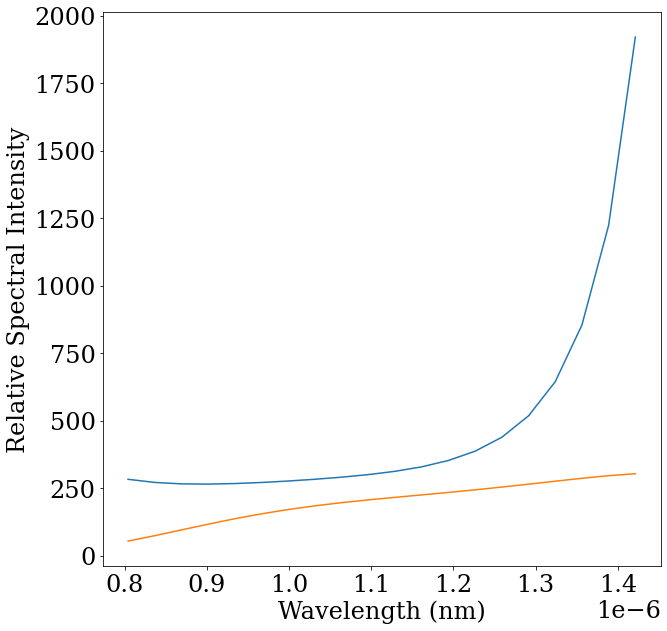

In [25]:
plt.figure(figsize=(10,10))

wv, filt = calc_throughput("F110W", nwavels=nwavels)

#plt.plot(wavels, params.get("spectrum.U10764_F110W"))
plt.plot(wv, 10**(NonNormalisedClippedPolySpectrum(np.linspace(-1, 1, nwavels), models[-1].get("primary_spectrum.U20081_F110W")).weights))#), yerr = spectrum_err)
plt.plot(wv, 10**(NonNormalisedClippedPolySpectrum(np.linspace(-1, 1, nwavels), models[-1].get("secondary_spectrum.U20081_F110W")).weights))#), yerr = spectrum_err)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Relative Spectral Intensity")

In [26]:
rc = True
fishers = calc_fishers(models[-1].inject(model_binary), exposures_binary, groups, recalculate=rc)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [27]:
fishers

{'n8yj59glq': {'positions': Array([[ 4.46642471e+08, -1.02018702e+07],
         [-1.02018702e+07,  3.67729030e+08]], dtype=float64),
  'separation': Array([[1.16152467e+08]], dtype=float64),
  'position_angle': Array([[359714.42546618]], dtype=float64),
  'primary_spectrum': Array([[2.42156881e+09, 7.88567952e+08, 1.24502143e+09, 6.46289834e+08,
          9.61618470e+08],
         [7.88567952e+08, 2.88121649e+08, 4.08410361e+08, 2.28814616e+08,
          3.14875539e+08],
         [1.24502143e+09, 4.08410361e+08, 6.41718909e+08, 3.33925068e+08,
          4.95713996e+08],
         [6.46289834e+08, 2.28814616e+08, 3.33925068e+08, 1.83228250e+08,
          2.57532902e+08],
         [9.61618470e+08, 3.14875539e+08, 4.95713996e+08, 2.57532902e+08,
          3.82929281e+08]], dtype=float64),
  'secondary_spectrum': Array([[7.52380599e+08, 1.23738027e+08, 2.57276501e+08, 9.10048303e+07,
          1.66281620e+08],
         [1.23738027e+08, 2.47990249e+07, 4.25184339e+07, 1.71712817e+07,
       

In [28]:
aberration_names = [dlu.zernike_name(x) for x in range(40)]
poly_names = ["poly "+ x for x in ["0", "1", "2", "3", "4"]]

In [29]:
models[-1].params

{'aberrations': {'n8yj59glq': Array([ 1.6139325 , -3.92938082,  3.03428809,  0.9762199 ,  7.05615155,
          3.14563956,  0.66279922,  3.5678507 ,  0.48973107,  2.40058034,
          3.16516601, -1.73970976, -5.85726729,  0.53143434, -0.01091188,
         -1.52928541,  0.19273844, -3.02492805, -1.52844561,  0.24302021,
          0.1992252 ,  0.90849038, -1.18120154, -1.58531078, -1.17195604,
          1.36381625], dtype=float64)},
 'cold_mask_rot': {'F110W': Array(-45.00351431, dtype=float64)},
 'cold_mask_scale': {'F110W': Array([1., 1.], dtype=float64)},
 'cold_mask_shear': {'F110W': Array([0., 0.], dtype=float64)},
 'cold_mask_shift': {'n8yj59glq': Array([4.95263505, 6.99498959], dtype=float64)},
 'contrast': OrderedDict([('F110W', 1.0)]),
 'fluxes': OrderedDict([('U20081_F110W', Array(-0.46679134, dtype=float64))]),
 'outer_radius': 1.146,
 'position_angle': Array(11.36959487, dtype=float64),
 'positions': {'n8yj59glq': Array([ 0.13958356, -2.01236223], dtype=float64)},
 'primar

In [30]:
np.sqrt((np.linalg.inv(fishers['n8yj59glq']['position_angle'])))[0][0]

Array(0.00166733, dtype=float64)

In [31]:
np.sqrt((np.linalg.inv(fishers['n8yj59glq']['separation'])))[0][0]

Array(9.27867109e-05, dtype=float64)

In [32]:
np.diag(np.sqrt(np.linalg.inv(fishers['n8yj59glq']['secondary_spectrum'])))

Array([0.00101695, 0.00371849, 0.009572  , 0.00747211, 0.01224122],      dtype=float64)

In [33]:
#potato

In [34]:

def make_psf_model(modelparams, fishers):

    def psf_model(data, model):

        params = {
            "primary_spectrum": {},
            "secondary_spectrum": {},
            "positions": {},
            #"position_angle": 0., 
            #"separation": 0. , 
            "cold_mask_shift": {},
            "aberrations": {},
        }

        for exp in exposures_binary:
            #params["fluxes"][exp.fit.get_key(exp, "fluxes")] = npy.sample("Flux", dist.Normal(0,1))*np.sqrt(np.abs(np.linalg.inv(fishers['n8yj53vfq']['fluxes'])))[0][0] + modelparams.get(exp.map_param("fluxes"))

            params["position_angle"] = npy.sample("Position Angle", dist.Normal(0, 1))*np.sqrt(np.abs(np.linalg.inv(fishers['n8yj59glq']['position_angle'])))[0][0] + modelparams.get("position_angle")

            params["separation"] = npy.sample("Separation", dist.Normal(0, 1))*np.sqrt(np.abs(np.linalg.inv(fishers['n8yj59glq']['separation'])))[0][0] + modelparams.get("separation")

            params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([npy.sample("Cold X", dist.Normal(0, 1))*np.sqrt(np.abs(np.linalg.inv(fishers['n8yj59glq']['cold_mask_shift'])))[0][0] + modelparams.get(exp.map_param("cold_mask_shift"))[0], npy.sample("Cold Y", dist.Normal(0, 1))*np.sqrt(np.abs(np.linalg.inv(fishers['n8yj59glq']['cold_mask_shift'])))[1][1] + modelparams.get(exp.map_param("cold_mask_shift"))[1]])
            
            params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([npy.sample("X", dist.Normal(0,1))*np.sqrt(np.abs(np.linalg.inv(fishers['n8yj59glq']['positions'])))[0][0] + modelparams.get(exp.map_param("positions"))[0], npy.sample("Y", dist.Normal(0, 1))*np.sqrt(np.abs(np.linalg.inv(fishers['n8yj59glq']['positions'])))[1][1] + modelparams.get(exp.map_param("positions"))[1]])

            params["primary_spectrum"][exp.fit.get_key(exp, "primary_spectrum")] = np.asarray([
                npy.sample("primary "+poly_names[x], dist.Normal(0,1))/np.sqrt(fishers['n8yj59glq']['primary_spectrum'][i][i]) + modelparams.get(exp.map_param("primary_spectrum"))[i] for i, x in enumerate(range(0,5))
                
            ])

            params["secondary_spectrum"][exp.fit.get_key(exp, "secondary_spectrum")] = np.asarray([
                npy.sample("secondary " + poly_names[x], dist.Normal(0,1))/np.sqrt(fishers['n8yj59glq']['secondary_spectrum'][i][i]) + modelparams.get(exp.map_param("secondary_spectrum"))[i] for i, x in enumerate(range(0,5))
                
            ])


            params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.asarray([
                npy.sample(aberration_names[x], dist.Normal(0,1))/np.sqrt(fishers['n8yj59glq']['aberrations'][i][i]) + modelparams.get(exp.map_param("aberrations"))[i] for i, x in enumerate(range(4,30))
                
            ])

        params = ModelParams(params)

        
        
        with npy.plate("data", size=len(data.data.flatten())):

            mdl = params.inject(model)
            model_data = data.fit(mdl, data).flatten()
            img, err, bad = data.data.flatten(), data.err.flatten(), data.bad.flatten()
            image = np.where(bad, 0, img)
            error = np.where(bad, 1e5, err)
            
            image_d = dist.Normal(image, error)
            return npy.sample("psf", image_d, obs=np.where(bad,0,model_data))
    
    return psf_model



sampler = npy.infer.MCMC(
    npy.infer.NUTS(make_psf_model(models[-1], jtu.tree_map(lambda x: np.abs(x), fishers)), 
                   init_strategy=npy.infer.init_to_sample,
                    dense_mass=False),
    num_warmup=500,
    num_samples=500,
    #num_chains=6,
    #chain_method='vectorized'
    progress_bar=True,
)

sampler.run(jr.PRNGKey(0),exposures_binary[0], model_binary)

sampler.print_summary()

chain = cc.Chain.from_numpyro(sampler, name="numpyro chain", color="teal")
consumer = cc.ChainConsumer().add_chain(chain)
#consumer = consumer.add_truth(cc.Truth(location={"X":-3e-7/pixel_scale, "Y":1e-7/pixel_scale, "Flux":5,"Cold X":0.08, "Cold Y":0.08, "Defocus":5, "Cold Rot":np.pi/4}))

fig = consumer.plotter.plot()
#fig.savefig("chains_hmc_data.png")
#plt.close()

plt.show()

warmup:   3%|▎         | 30/1000 [09:00<4:51:29, 18.03s/it, 15 steps of size 5.76e-04. acc. prob=0.68]  


KeyboardInterrupt: 